In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from parse_generators import parse_generators, parse_proposed, parse_retired

In [2]:
capacity_by_year = {}
plant_age_by_year = {}
df_by_year = {}
YEARS = [2010, 2018]

In [3]:
# source: https://www.eia.gov/electricity/data/eia860/
for year in YEARS:
    df_by_year[year] = parse_generators(year)
df_proposed = parse_proposed(2018)

In [4]:
df_by_year[2010][
    df_by_year[2010].energy_source == 'wind'
].head()

,utility_name,plant_name,state,county,status,sector,nameplate_capacity,energy_source_1,operating_year,planned_retirement_year,energy_source
generator_uuid,,,,,,,,,,,
508_T1-T3,City of Lamar,Lamar Plant,CO,Prowers,OP,Electric Utility,4.5,WND,2004,NaN,wind
508_T4,City of Lamar,Lamar Plant,CO,Prowers,OP,Electric Utility,1.5,WND,2004,NaN,wind
692_10,Platte River Power Authority,Medicine Bow,WY,Carbon,OP,Electric Utility,0.7,WND,2000,NaN,wind
692_11,Platte River Power Authority,Medicine Bow,WY,Carbon,OP,Electric Utility,0.7,WND,2000,NaN,wind
692_1A,Platte River Power Authority,Medicine Bow,WY,Carbon,OP,Electric Utility,0.6,WND,1998,NaN,wind


## capacity

In [5]:
for year in YEARS:
    capacity_by_year[year] = df_by_year[year].groupby('energy_source').nameplate_capacity.sum().sort_values(ascending=False).round().astype(int)

## plant age

In [6]:
for year in YEARS:
    grp = df_by_year[year].assign(age_weighted=(year - df_by_year[year].operating_year) * df_by_year[year].nameplate_capacity).groupby('energy_source')
    plant_age_by_year[year] = (grp.age_weighted.sum() / grp.nameplate_capacity.sum()).round(1).loc[capacity_by_year[year].index]

In [7]:
df = df_by_year[2018]
# planned additions
planned_additions = df_proposed[
    (df_proposed.effective_year >= year) & (df_proposed.effective_year <= 2020)
].groupby('energy_source').nameplate_capacity.sum()
print('additions:')
print(planned_additions.sort_values(ascending=False))

# retirements
retirements = df[df.planned_retirement_year <= 2020].groupby('energy_source').nameplate_capacity.sum()
print('retirements:')
print(retirements.sort_values(ascending=False))

# planned additions
capacity_by_year['2020 est'] = (capacity_by_year[year] + planned_additions.reindex_like(capacity_by_year[year]).fillna(0) - retirements.reindex_like(capacity_by_year[year]).fillna(0)).round().astype(int)

additions:
energy_source
natural gas    13106.0
wind           10876.0
solar           7924.5
coal             850.0
by-products      197.5
storage          131.8
other             50.9
oil               35.7
hydro             32.4
Name: nameplate_capacity, dtype: float64
retirements:
energy_source
coal           19416.5
natural gas     7802.0
nuclear         4554.5
by-products      235.9
hydro            124.4
oil              116.0
wind              75.0
solar              9.4
other              5.1
Name: nameplate_capacity, dtype: float64


# results

In [8]:
df_capacity_by_year = pd.DataFrame(capacity_by_year).loc[capacity_by_year[2018].index]
print(df_capacity_by_year)

                 2010    2018  2020 est
energy_source                          
natural gas    395185  477154    482458
coal           329752  254839    236272
nuclear        106731  104270     99716
hydro           97463   97029     96937
wind            39318   94726    105527
solar             901   31842     39757
oil             54449   31738     31658
by-products      5497    6517      6479
other            4720    3731      3777
storage            29     889      1021


In [9]:
print((df_capacity_by_year.div(df_capacity_by_year.sum(axis=0), axis=1)).round(3))

                2010   2018  2020 est
energy_source                        
natural gas    0.382  0.433     0.437
coal           0.319  0.231     0.214
nuclear        0.103  0.095     0.090
hydro          0.094  0.088     0.088
wind           0.038  0.086     0.096
solar          0.001  0.029     0.036
oil            0.053  0.029     0.029
by-products    0.005  0.006     0.006
other          0.005  0.003     0.003
storage        0.000  0.001     0.001


coal plants are getting older

In [10]:
print(pd.DataFrame(plant_age_by_year).loc[capacity_by_year[2018].index][YEARS])

               2010  2018
energy_source            
natural gas    16.9  20.5
coal           36.3  39.5
nuclear        29.2  36.7
hydro          46.6  53.5
wind            3.5   6.7
solar          10.5   2.9
oil            34.5  39.5
by-products    19.2  22.1
other          20.9  26.2
storage         6.6   2.9


## capacity additions by year

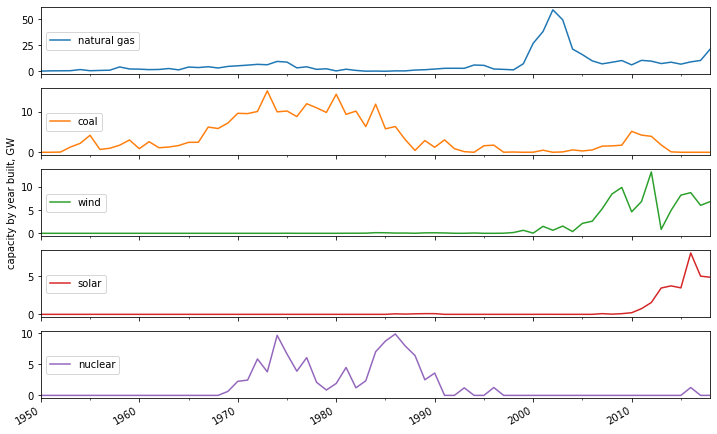

In [29]:
# huge NG capacity build out in 2000-2004 appears to be related to low inflation and natural gas prices
# might be an artifact, but does appear in 2010 and 2018 data
built_year = (
    df.groupby(['operating_year', 'energy_source']).nameplate_capacity.sum().unstack() / 1000
).fillna(0).loc[1950:][[
    'natural gas',
    'coal',
    'wind',
    'solar', 
    'nuclear',
    # 'oil',
]]
# built_year.loc[2000:2004, "natural gas"] = np.nan
built_year.index = pd.to_datetime(built_year.index.astype(int).astype(str))
axes = built_year.plot(subplots=True, figsize=(12, 8))
axes[2].set_ylabel('capacity by year built, GW')
for ax in axes:
    ax.legend(loc='center left');
    
plt.savefig('generation-capacity.png')

In [26]:
plt.savefig?

In [21]:
## biggest year, renewables

In [24]:
built_year.loc['2000':'2004']

energy_source,natural gas,coal,wind,solar,nuclear
2000-01-01,26.9798,0.0180,0.0391,0.0000,0.0
2001-01-01,38.3031,0.5137,1.5068,0.0039,0.0
2002-01-01,59.2114,0.0000,0.6577,0.0021,0.0
2003-01-01,49.6144,0.0900,1.5596,0.0000,0.0
2004-01-01,21.4370,0.5850,0.3750,0.0000,0.0


In [25]:
built_year.loc['2010':][['wind', 'solar']]

energy_source,wind,solar
2010-01-01,4.6393,0.2132
2011-01-01,6.8634,0.7506
2012-01-01,13.2559,1.5608
2013-01-01,0.8525,3.4714
2014-01-01,4.9395,3.7551
2015-01-01,8.2449,3.4920
2016-01-01,8.7821,8.0965
2017-01-01,6.0435,5.0403
2018-01-01,6.8658,4.8889


# other

In [12]:
df_by_year[2018].groupby('state').nameplate_capacity.sum().sort_values(ascending=False).head(10)

state
TX    112027.2
CA     71616.4
FL     61531.9
PA     50632.4
IL     48692.9
NY     38075.0
GA     37879.4
NC     35315.7
OH     31554.5
AZ     31407.7
Name: nameplate_capacity, dtype: float64

In [13]:
# the 2001-2004 boom NG capacity boom doesn't seem right
ng_boom = df[(df.energy_source == 'natural gas') & (df.operating_year > 2000) & (df.operating_year < 2005)]
print(ng_boom.nameplate_capacity.sum() / 1000)
# 168 GW is way too much

168.56590000000003


In [14]:
# most of this is non-utility, and the rules changed in 2000 for what got recorded where
ng_boom.groupby('sector').nameplate_capacity.sum()#.sort_values(ascending=False).head(30)

sector
Electric Utility    75752.2
IPP Non-CHP         92813.7
Name: nameplate_capacity, dtype: float64

In [15]:
ng_boom[ng_boom.sector == 'IPP Non-CHP'].sort_values('nameplate_capacity', ascending=False).head()

,utility_name,plant_name,state,county,status,sector,nameplate_capacity,energy_source_1,operating_year,planned_retirement_year,energy_source
generator_uuid,,,,,,,,,,,
55503.0_ST1,"Waterford Power, LLC","Waterford Power, LLC",OH,Washington,OP,IPP Non-CHP,399.0,NG,2003.0,NaN,natural gas
55439.0_STG1,Tenaska Virginia Partners LP,Tenaska Virginia Generating Station,VA,Fluvanna,OP,IPP Non-CHP,396.2,NG,2004.0,NaN,natural gas
55271.0_STG1,Tenaska Alabama Partners LP,Tenaska Lindsay Hill Generating Station,AL,Autauga,OP,IPP Non-CHP,390.1,NG,2002.0,NaN,natural gas
55440.0_ST1,Tenaska Alabama B LP,Tenaska Central Alabama Generating Stn,AL,Autauga,OP,IPP Non-CHP,390.1,NG,2003.0,NaN,natural gas
55132.0_STG1,Tenaska Gateway Partners Ltd,Tenaska Gateway Generating Station,TX,Rusk,OP,IPP Non-CHP,390.0,NG,2001.0,NaN,natural gas


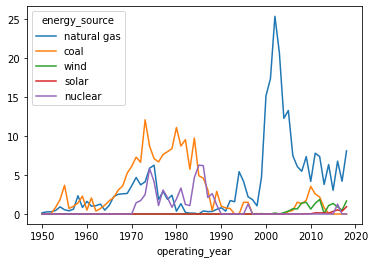

In [16]:
(
    df[df.sector != 'IPP Non-CHP'].groupby(['operating_year', 'energy_source']).nameplate_capacity.sum().unstack() / 1000
).fillna(0).loc[1950:][[
    'natural gas',
    'coal',
    'wind',
    'solar', 
    'nuclear',
    # 'oil',
]].plot()

In [17]:
df_retired = parse_retired(2018)

In [18]:
capacity = {}
source_stack = [
    'nuclear',
    'coal',
    'oil',
    'natural gas',
    'wind',
    'solar', 
]
for year in range(1950, 2021):
    capacity[year] = (
        df[
            (df.operating_year <= year)
        ].groupby('energy_source').nameplate_capacity.sum().reindex(source_stack, fill_value=0) -
        df_retired[
            (df_retired.retirement_year <= year) &
            (df_retired.operating_year <= year)
        ].groupby('energy_source').nameplate_capacity.sum().reindex(source_stack, fill_value=0)
    )
capacity = pd.DataFrame(capacity).fillna(0).T / 1000

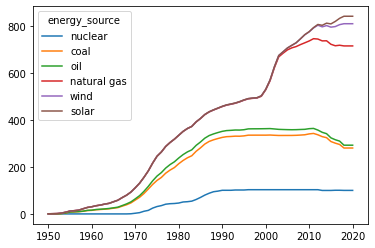

In [19]:
capacity[source_stack].plot(stacked=True);

In [20]:
# fig2.2 in report from EIA: https://www.eia.gov/analysis/studies/powerplants/generationcost/pdf/full_report.pdf
# and E-GRID data from EPA: https://www.epa.gov/sites/production/files/2020-03/egrid2018_data_v2.xlsx 
# also suggests that gas capacity boomed in early 2000s